In [158]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Подход 1: градиентный бустинг "в лоб"

1. Считываем таблицу с признаками из файла features.csv. Удаляем признаки, связанные с итогами матча (кроме столбца с победителем 'radiant_win').

In [65]:
features = pd.read_csv('features.csv', index_col = 'match_id')
features.drop(['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis = 1, inplace = True)

2. Проверяем выборку на наличие пропусков. Запишем названия признаков, имеющих пропуски и доли пропусков от общего числа игр.

In [71]:
nulls = round(features.isnull().sum()[features.isnull().sum() != 0] / len(features) * 100, 1)
print(nulls.sort_values(ascending=False))

first_blood_player2            45.2
radiant_flying_courier_time    28.3
dire_flying_courier_time       26.8
first_blood_player1            20.1
first_blood_team               20.1
first_blood_time               20.1
dire_bottle_time               16.6
radiant_bottle_time            16.1
dire_first_ward_time            1.9
radiant_first_ward_time         1.9
dire_courier_time               0.7
radiant_courier_time            0.7
dtype: float64


Обоснование пропусков:

* first_blood_time (игровое время до первой крови) - в 20.1% случаев первой крови нет в первые 5 минут игры.
* first_blood_team (команда, совершившая первую кровь) - аналогично first_blood_time.
* first_blood_player1 (игрок, причастный к первой крови) - аналогично first_blood_time.
* first_blood_player2 (второй игрок, причастный к первой крови) - первое убийство может быть совершено одним игроком (без участия второго), это самое частое явление и происходит в 45.2% случаев.

* radiant_flying_courier_time (время приобретения предмета 'flying_courier') - в 28.3% случаев команда 'radiant' не приобретает этот предмет в первые 5 минут игры.
* dire_flying_courier_time - аналогично для команды 'dire' (26.8%).

* radiant_bottle_time (время первого приобретения командой предмета "bottle") - в 16.1% случаев команда 'radiant' не приобретает этот предмет в первые 5 минут игры.
* dire_bottle_time - аналогично для команды 'dire' (16.6%).

* radiant_first_ward_time, dire_first_ward_time (время установки командой первого 'наблюдателя') - очень редкое явление, в 1.9% случаев команды не ставят наблюдателя в первые 5 минут игры.

* radiant_courier_time, dire_courier_time (время приобретения предмета 'courier') - самое редкое явление, в 0.7% случаев команды не приобретают этот предмет в первые 5 минут игры.

3. Заменим пропуски на нули

In [50]:
features.fillna(value = 0, inplace = True)

4. Целевая переменная в задаче - признак победы команды 'radiant'. Это последний столбец таблицы признаков.

In [51]:
print(features.columns.values[-1])

radiant_win


5. Попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируем генератор разбиений для кросс-валидации по 5 блокам, перемешаем выборку.

In [52]:
X_train = features.drop('radiant_win', axis = 1)
y_train = features['radiant_win']

In [53]:
kf = KFold(n_splits = 5, shuffle = True) # создание генератора разбиений

Оценим качество градиентного бустинга с помощью данной кросс-валидации, попробуем при этом разное количество деревьев (10, 20, ..., 250, см. переменную n_list).

In [61]:
scores = {}
etimes = {}

n_list = [10, 20, 30, 50, 100, 150, 200, 250]
for n in n_list:
    gbc = GradientBoostingClassifier(n_estimators = n)
    
    start_time = datetime.datetime.now()
    
    score = cross_val_score(gbc, X_train, y_train, cv = kf, scoring = 'roc_auc').mean()
    
    elapsed_time = datetime.datetime.now() - start_time
    scores[n] = score
    etimes[n] = elapsed_time

## Обработка результатов

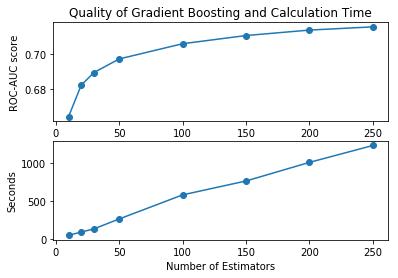

In [193]:
s = []
for i in n_list:
    s.append(etimes[i].total_seconds())
plt.plot(etimes.keys(), s)

plt.subplot(2, 1, 1)
plt.plot(scores.keys(), scores.values(), 'o-')
plt.title('Quality of Gradient Boosting and Calculation Time')
plt.ylabel('ROC-AUC score')

plt.subplot(2, 1, 2)
plt.plot(etimes.keys(), s, 'o-')
plt.xlabel('Number of Estimators')
plt.ylabel('Seconds')
plt.show()

In [194]:
print('n_estimators = 250. Scores =', round(max(scores.values()),2), 'Elapsed time =', round(max(etimes.values()).total_seconds(), 0), 'seconds')
print('n_estimators = 30. Scores =', round(scores[30],2), 'Elapsed time =', round(etimes[30].total_seconds(),0), 'seconds')

n_estimators = 250. Scores = 0.72 Elapsed time = 1228.0 seconds
n_estimators = 30. Scores = 0.69 Elapsed time = 135.0 seconds


Классификаторы настраивались очень долго. Максимальное время при 250 деревьях превысило 20 минут. При этом оптимум на испытанных значениях параметра n_estimators (до 250) не достигнут и качество продолжает расти при увеличении числа деревьев. Для достижения большего качества имеет смысл использовать более 30 деревьев, поскольку точность результатов повышается. Для ускорения обучения можно использовать не всю выборку, а некоторое ее подмножество — например, половину объектов. Можно также уменьшить глубину деревьев (max_depth).

# Подход 2: логистическая регрессия

Оценим качество логистической регрессии с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга.

In [177]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index = X_train.index, columns = X_train.columns)

c = np.power(10.0, np.arange(-5, 5))
scores2 = {}
etimes2 = {}

for p_reg in c:
    log_reg = LogisticRegression(C = p_reg, penalty = 'l2', solver = 'lbfgs', random_state = 42)

    start_time = datetime.datetime.now()
    score = cross_val_score(log_reg, X_train, y_train, cv = kf, scoring = 'roc_auc').mean()
    elapsed_time = datetime.datetime.now() - start_time
    scores2[p_reg] = score
    etimes2[p_reg] = elapsed_time

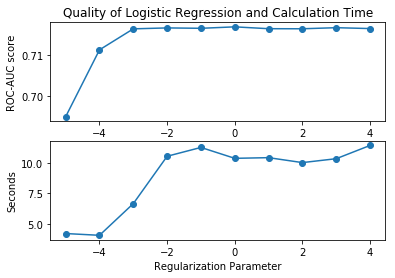

In [197]:
s2 = []
for i in c:
    s2.append(etimes2[i].total_seconds())

plt.subplot(2, 1, 1)
plt.plot(np.log10(c), scores2.values(), 'o-')
plt.title('Quality of Logistic Regression and Calculation Time')
plt.ylabel('ROC-AUC score')

plt.subplot(2, 1, 2)
plt.plot(np.log10(c), s2, 'o-')
plt.xlabel('Regularization Parameter')
plt.ylabel('Seconds')
plt.show()

In [204]:
print('C_best =', list(scores2.keys())[list(scores2.values()).index(max(scores2.values()))], 'Scores =', round(max(scores2.values()),2), 'Elapsed time =', round(max(etimes2.values()).total_seconds(), 0), 'seconds')

print(round(sum(s)/sum(s2[4:]), 0))

C_best = 1.0 Scores = 0.72 Elapsed time = 11.0 seconds
67.0


Наилучший результат алгоритма - 0.72 (также как и у метода градиентного бустинга). Наилучший параметр регуляризации C = 1 (однако уже при C = 0.01 результат практически не отличается от максимального). При этом метод логистической регрессии работает в 67 раз быстрее (оцениваем время до достижения максимального результата у каждого алгоритма). Отсутствие разницы с градиентным бустингом может говорить о линейной зависимости между признаками и целевой переменной. Такая связь хорошо описывается логистической регрессией и применять более сложные модели не целесообразно. 

Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберем их из выборки, и проведем кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации.

In [206]:
hero_columns = [f'r{i}_hero' for i in range (1, 6)] + [f'd{i}_hero' for i in range (1, 6)]
cat_columns = ['lobby_type'] + hero_columns

X_train_cut = X_train.drop(cat_columns, axis = 1)

In [207]:
X_train_cut = pd.DataFrame(scaler.fit_transform(X_train_cut), index = X_train_cut.index, columns = X_train_cut.columns)

scores3 = {}
etimes3 = {}

for p_reg in c:
    log_reg = LogisticRegression(C = p_reg, penalty = 'l2', solver = 'lbfgs', random_state = 42)

    start_time = datetime.datetime.now()
    score = cross_val_score(log_reg, X_train_cut, y_train, cv = kf, scoring = 'roc_auc').mean()
    elapsed_time = datetime.datetime.now() - start_time
    scores3[p_reg] = score
    etimes3[p_reg] = elapsed_time

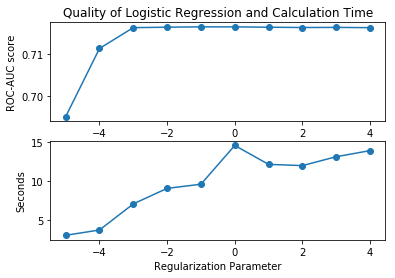

In [209]:
s3 = []
for i in c:
    s3.append(etimes3[i].total_seconds())

plt.subplot(2, 1, 1)
plt.plot(np.log10(c), scores3.values(), 'o-')
plt.title('Quality of Logistic Regression and Calculation Time')
plt.ylabel('ROC-AUC score')

plt.subplot(2, 1, 2)
plt.plot(np.log10(c), s3, 'o-')
plt.xlabel('Regularization Parameter')
plt.ylabel('Seconds')
plt.show()

In [210]:
print('C_best =', list(scores3.keys())[list(scores3.values()).index(max(scores3.values()))], 'Scores =', round(max(scores3.values()),2), 'Elapsed time =', round(max(etimes3.values()).total_seconds(), 0), 'seconds')

C_best = 0.1 Scores = 0.72 Elapsed time = 15.0 seconds


Наилучшее значение показателя AUC-ROC достигается при C = 0.1 и также равно 0.72.
Удаление категориальных признаков не повлияло на качество предсказания. Это означает, что в предыдущей модели эти признаки никак не влияли на результат предсказания (модель оказалась устойчива).

На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясним из данных, сколько различных идентификаторов героев существует в данной игре

In [245]:
X_train_heroes = features.drop('radiant_win', axis = 1)
X_train_heroes = X_train_heroes[hero_columns]
unique_heroes = np.unique(X_train_heroes.values.ravel())

L = len(unique_heroes)
N = max(unique_heroes)

print('В играх участвовали', L, 'уникальных героев')

В играх участвовали 108 уникальных героев


Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеется N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire.

In [249]:
X_heroes = np.zeros((X_train_heroes.shape[0], N))
for i, match_id in enumerate(X_train_heroes.index):
    for p in range(1, 6):
        X_heroes[i, X_train_heroes.loc[match_id, f'r{p}_hero'] - 1] = 1
        X_heroes[i, X_train_heroes.loc[match_id, f'd{p}_hero'] - 1] = -1

X_heroes = pd.DataFrame(X_heroes, index = X_train_heroes.index, columns=[f'hero_{i}' for i in range(N)])
print(X_heroes.head())

          hero_0  hero_1  hero_2  hero_3  hero_4  hero_5  hero_6  hero_7  \
match_id                                                                   
0            0.0     0.0     0.0    -1.0     0.0     0.0     0.0     0.0   
1            0.0     0.0     0.0     0.0     0.0     0.0    -1.0     0.0   
2            0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
3            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4            0.0     0.0     0.0     0.0     0.0     0.0     0.0    -1.0   

          hero_8  hero_9    ...     hero_102  hero_103  hero_104  hero_105  \
match_id                    ...                                              
0            0.0     0.0    ...          0.0       0.0       1.0       0.0   
1            0.0     0.0    ...          0.0       0.0       0.0       0.0   
2            0.0     0.0    ...          0.0       0.0       0.0       0.0   
3            0.0     0.0    ...          0.0       0.0       0.0       0.0   

Добавим полученные признаки к числовым, которые мы использовали во втором пункте данного этапа.

In [251]:
X_train_with_heroes = pd.concat([X_train_cut, X_heroes], axis = 1)
#print(X_train_with_heroes)

Проведем кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. 

In [252]:
X_train_with_heroes = pd.DataFrame(scaler.fit_transform(X_train_with_heroes), index = X_train_with_heroes.index, columns = X_train_with_heroes.columns)

c = np.power(10.0, np.arange(-5, 5))
scores4 = {}
etimes4 = {}

for p_reg in c:
    log_reg = LogisticRegression(C = p_reg, penalty = 'l2', solver = 'lbfgs', random_state = 42)

    start_time = datetime.datetime.now()
    score = cross_val_score(log_reg, X_train_with_heroes, y_train, cv = kf, scoring = 'roc_auc').mean()
    elapsed_time = datetime.datetime.now() - start_time
    scores4[p_reg] = score
    etimes4[p_reg] = elapsed_time

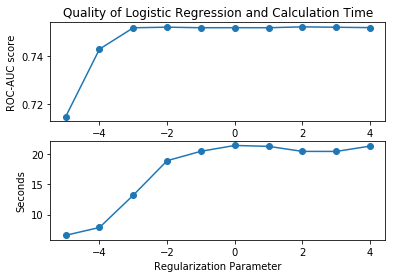

In [253]:
s4 = []
for i in c:
    s4.append(etimes4[i].total_seconds())

plt.subplot(2, 1, 1)
plt.plot(np.log10(c), scores4.values(), 'o-')
plt.title('Quality of Logistic Regression and Calculation Time')
plt.ylabel('ROC-AUC score')

plt.subplot(2, 1, 2)
plt.plot(np.log10(c), s4, 'o-')
plt.xlabel('Regularization Parameter')
plt.ylabel('Seconds')
plt.show()

In [254]:
print('C_best =', list(scores4.keys())[list(scores4.values()).index(max(scores4.values()))], 'Scores =', round(max(scores4.values()),2), 'Elapsed time =', round(max(etimes4.values()).total_seconds(), 0), 'seconds')

C_best = 100.0 Scores = 0.75 Elapsed time = 21.0 seconds


Наилучшее значение показателя AUC-ROC достигается при C = 100 и равно 0.75. После добавления "мешка слов" по героям качество обучения заметно улучшилось. Это связано с тем, что вместо отсутствия данных о героях или случайного шума  мы использовали их категориальные признаки для построения предсказания.

Построим предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (с точки зрения AUC-ROC на кросс-валидации).

In [267]:
log_reg = LogisticRegression(C = 100, penalty = 'l2', solver = 'lbfgs', random_state = 42)
log_reg.fit(X_train_with_heroes, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [292]:
features_test = pd.read_csv('features_test.csv', index_col = 'match_id')
features_test.fillna(value = 0, inplace = True)

X_test = features_test
X_test_heroes = X_test[hero_columns]

X_test = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

In [296]:
X_test_cut = X_test.drop(cat_columns, axis = 1)

X_heroes = np.zeros((X_test_cut.shape[0], N))
for i, match_id in enumerate(X_test_heroes.index):
    for p in range(1, 6):
        X_heroes[i, X_test_heroes.loc[match_id, f'r{p}_hero'] - 1] = 1
        X_heroes[i, X_test_heroes.loc[match_id, f'd{p}_hero'] - 1] = -1

X_heroes = pd.DataFrame(X_heroes, index = X_test_heroes.index, columns = [f'hero_{i}' for i in range(N)])
X_test = pd.concat([X_test_cut, X_heroes], axis=1)
print(X_test.head())

          start_time  r1_level     r1_xp   r1_gold     r1_lh  r1_kills  \
match_id                                                                 
6          -2.514875  0.474746 -0.237743 -0.137094 -0.370005 -0.532732   
7          -2.513895 -1.365630 -1.207913 -1.255660 -1.145090 -0.532732   
10         -2.512377 -1.365630 -0.862057 -0.742715 -1.145090 -0.532732   
13         -2.508381 -0.445442 -0.938323 -0.537967 -1.145090  0.968865   
16         -2.507087  0.474746  0.038942 -1.059534 -0.812911 -0.532732   

          r1_deaths  r1_items  r2_level     r2_xp    ...     hero_102  \
match_id                                             ...                
6          1.003884  0.305165 -0.368985  0.003979    ...          0.0   
7         -0.593200  0.305165  0.567766  0.023887    ...          0.0   
10        -0.593200  1.898546 -1.305736 -1.375081    ...          0.0   
13         1.003884  1.101855 -1.305736 -0.920823    ...          0.0   
16        -0.593200  0.305165  1.504517  0.

In [306]:
predications = pd.Series(log_reg.predict_proba(X_test)[:, 1])

Убедимся, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т. е. что модель не получилась константной).

In [307]:
print(predications.describe())

count    17177.000000
mean         0.519837
std          0.211957
min          0.006602
25%          0.359940
50%          0.522135
75%          0.684340
max          0.995602
dtype: float64


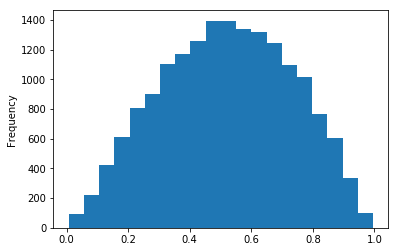

In [308]:
predications.plot.hist(bins = 20)

In [305]:
print('Минимальная вероятность победы команды Rafiant -', round(min(predications), 3), 'максимальная -', round(max(predications),3))

Минимальная вероятность победы команды Rafiant - 0.007 максимальная - 0.996
